In [1]:
#import some stuff
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import random
import math
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def clean_memory():
    gc.collect()           # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear cached memory on GPU


data_dir = "C:/Users/yueze/Desktop/GPT_two_qubit_polarization_tracking/data_3.csv"
df = pd.read_csv(data_dir)
print(df.head)

features = ["AI0","AI1","AI2"]
targets  = ["AI3","AI4","AI5"]
x = df[features]  # Dropping original targets as we'll use aligned targets
y = df[targets]  # Using aligned targets
split_idx = int(len(df) * 0.9)
length_read=len(df)
# Split into training and testing sets
x_train = x.iloc[:split_idx]
y_train = y.iloc[:split_idx]
x_test = x.iloc[split_idx:]
y_test = y.iloc[split_idx:]

input_feature_dim = 3  # Each input element is a 1x3 vector
embed_size = 128
target_dim = 3
block_size = 100
num_heads = 32
max_iters = 500
batch_size = 10
eval_iters = 200
eval_interval = 1
num_layers=5

def get_batch3(split):
    # Select the correct data split
    if split == 'train':
        a, b, max_index = x_train, x_train, int(length_read * 0.9) - block_size - 1
    else:  # split == 'test'
        a, b, max_index = x_test, x_test, length_read - (int(length_read * 0.9) + block_size + 1)

    # Generate random indices for batch selection, ensuring they're within bounds
    ix = torch.randint(0, max_index, (batch_size,))
    print(f"Batch indices: {ix}")
    # Initialize lists to hold the batches
    x_batch = []
    y_batch = []

    for i in ix:
        try:
            # Extract sequences from 'a' and 'b' and the corresponding target from 'b'
            seq_A = torch.tensor(a.iloc[i.item():i.item() + block_size+1].astype(np.float32).values, dtype=torch.float32)
            seq_B = torch.tensor(b.iloc[i.item():i.item() + block_size+1].astype(np.float32).values, dtype=torch.float32)
            target = torch.tensor(b.iloc[i.item() + block_size].astype(np.float32).values, dtype=torch.float32)

            seq = torch.cat((seq_A, seq_B), dim=0)
            x_batch.append(seq)
            y_batch.append(target)
        except IndexError as e:
            print(f"IndexError for index {i.item()}: {str(e)}")
            print(f"Attempting to access index [{i.item()}:{i.item() + block_size}] in 'a' with shape {a.shape}")
            print(f"Attempting to access index {i.item() + block_size} in 'b' with shape {b.shape}")
            # Optionally, break or continue depending on desired behavior on error
            break  # or continue

    if not x_batch or not y_batch:
        print("Error: Batch could not be created due to index issues.")
        return None, None

    # Stack the collected sequences and targets into tensors
    xstack = torch.stack(x_batch)
    ystack = torch.stack(y_batch)

    return xstack, ystack


class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size

        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, x):
        K = self.keys(x)
        Q = self.queries(x)
        V = self.values(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.embed_size ** 0.5
        attention = torch.softmax(attention_scores, dim=-1)

        attended = torch.matmul(attention, V)
        return attended

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads

        assert embed_size % num_heads == 0

        self.head_dim = embed_size // num_heads

        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)

        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        keys = self.keys(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        queries = self.queries(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        values = self.values(x).view(batch_size, seq_length, self.num_heads, self.head_dim)

        attention_scores = torch.einsum("bnqh,bnkh->bnqk", [queries, keys]) / (self.head_dim ** 0.5)
        attention = torch.softmax(attention_scores, dim=-1)

        attended = torch.einsum("bnqk,bnkv->bnqv", [attention, values]).reshape(batch_size, seq_length, self.embed_size)

        output = self.fc_out(attended)
        return output

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch3(split)
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train
    del X, Y
    return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.dropout1 = nn.Dropout(0.1)

        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, 2 * embed_size),
            nn.ReLU(),
            nn.Linear(2 * embed_size, embed_size),
        )
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, value):
        x = self.norm1(value)
        attention_output = self.attention(x)
        x = value + self.dropout1(attention_output)  # Residual connection and dropout after attention
        x = self.norm2(x)
        feed_forward_output = self.feed_forward(x)
        out = value + self.dropout2(feed_forward_output)  # Residual connection and dropout after FFN
        return out

# Positional Encoding in Encoder class should be moved to the device
class Encoder(nn.Module):
    def __init__(self, input_feature_dim, embed_size, num_heads, num_layers, seq_length):
        super(Encoder, self).__init__()
        self.input_fc = nn.Linear(input_feature_dim, embed_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, embed_size)).to(device)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, num_heads) for _ in range(num_layers)])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_fc(x)) + self.positional_encoding
        for layer in self.layers:
            x = layer(x)
        return x
    
    def to_cpu(self):
        # Move the entire model to CPU
        self.input_fc.to('cpu')
        self.positional_encoding.data = self.positional_encoding.data.cpu()
        for layer in self.layers:
            layer.to('cpu')
        self.relu.to('cpu')
        torch.cuda.empty_cache()

class EncoderDecoderModelWithMultiHeadAttention(nn.Module):
    def __init__(self, input_feature_dim, embed_size, target_dim, seq_length, num_heads, num_layers):
        super(EncoderDecoderModelWithMultiHeadAttention, self).__init__()
        self.encoder = Encoder(input_feature_dim, embed_size, num_heads, num_layers, seq_length)
        self.decoder = nn.Sequential(
            nn.Linear(embed_size, target_dim),
        )

    def forward(self, x, targets):
        encoded = self.encoder(x)
        encoded_pooled = torch.mean(encoded, dim=1)
        decoded = self.decoder(encoded_pooled)
        
        if targets is not None:
            loss = criterion(decoded, targets)  
            return decoded, loss


        return decoded, None

    def to_cpu(self):
        self.encoder.to_cpu()
        for layer in self.decoder:
            layer.to('cpu')
        torch.cuda.empty_cache()
    


actuals = []
predictions = []


<bound method NDFrame.head of               AI0       AI1       AI2       AI3       AI4       AI5
0       -0.847375 -1.101343 -2.048840 -0.241758  1.623932 -1.814408
1       -0.847375 -1.150183 -2.039072 -0.231990  1.623932 -1.814408
2       -0.837607 -1.140415 -2.039072 -0.241758  1.623932 -1.814408
3       -0.827839 -1.159951 -2.039072 -0.241758  1.643468 -1.814408
4       -0.857143 -1.140415 -2.009768 -0.231990  1.623932 -1.814408
...           ...       ...       ...       ...       ...       ...
9999995  2.376069  0.676435  1.174604  1.145300 -0.017094  2.405373
9999996  2.278389  0.686203  1.106228  0.520147 -0.222222  2.356533
9999997  2.190477  0.949939  1.057387 -0.036630 -0.720390  2.122101
9999998  2.043956  0.989011  0.783883  0.920635 -0.134310  2.385837
9999999  2.317461  0.764347  1.037851  0.432235 -0.691086  2.141637

[10000000 rows x 6 columns]>


In [80]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EncoderDecoderModelWithMultiHeadAttention(input_feature_dim, embed_size, target_dim, block_size*2+2, num_heads, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for iter in range(max_iters):
        # Evaluate the loss periodically
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch3('train')
        xb, yb = xb.to(device), yb.to(device)  # Ensure these tensors are on the correct device

        predictions, loss = model(xb, yb)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
                # After using tensors in a training step
        del xb, yb, predictions  # Assuming these are not needed after the training step
        clean_memory()  # Call this to clear memoryq
    print("Loss:", loss.item())
    del loss  # Assuming these are not needed after the training step
    clean_memory()  # Call this to clear memoryq
    model.to_cpu()

step 0: train loss 1.6488, val loss 1.6242
step 1: train loss 0.1121, val loss 0.1146
step 2: train loss 0.9890, val loss 0.9976
step 3: train loss 0.6366, val loss 0.6428
step 4: train loss 0.2457, val loss 0.2532
step 5: train loss 0.1412, val loss 0.1349
step 6: train loss 0.2515, val loss 0.2434
step 7: train loss 0.3479, val loss 0.3401
step 8: train loss 0.3492, val loss 0.3442
step 9: train loss 0.2807, val loss 0.2820
step 10: train loss 0.1922, val loss 0.1922
step 11: train loss 0.1081, val loss 0.1162
step 12: train loss 0.0801, val loss 0.0810
step 13: train loss 0.0904, val loss 0.0935
step 14: train loss 0.1340, val loss 0.1302
step 15: train loss 0.1475, val loss 0.1482
step 16: train loss 0.1503, val loss 0.1471
step 17: train loss 0.1227, val loss 0.1176
step 18: train loss 0.0859, val loss 0.0889
step 19: train loss 0.0703, val loss 0.0706
step 20: train loss 0.0769, val loss 0.0805
step 21: train loss 0.0860, val loss 0.0905
step 22: train loss 0.1034, val loss 0.105

In [81]:
def prepare_full_dataset(x, y, block_size,length):
    full_sequences = []
    for i in range(length - block_size + 1):
        seq = torch.tensor(x.iloc[i:i + block_size+1].astype(np.float32).values)
        seq2 = torch.tensor(y.iloc[i:i + block_size+1].astype(np.float32).values)
        combined_seq = torch.cat((seq, seq2), dim=0)
        full_sequences.append(combined_seq)
    
    full_dataset = torch.stack(full_sequences)
    return full_dataset

# Prepare the full dataset and send it to the correct device
x_full = prepare_full_dataset(df[features],df[targets], block_size,10000)

In [82]:
batch_size = 1000
num_samples = x_full.size(0)  # Get the total number of samples
all_predictions = []

model.to_cpu()  # Ensure the model is on the CPU

with torch.no_grad():
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)  # Calculate the end index of the batch
        batch_x = x_full[start_idx:end_idx]  # Extract the batch
        predictions_batch, _ = model(batch_x, None)  # Get predictions for the batch
        all_predictions.append(predictions_batch.cpu())  # Collect the predictions

# Concatenate all batch predictions into a single tensor
predictions_full = torch.cat(all_predictions, dim=0)

In [38]:
def predictone(x, y,i):
    seq = torch.tensor(x.iloc[i:i + block_size].astype(np.float32).values)
    seq2 = torch.tensor(y.iloc[i:i + block_size-1].astype(np.float32).values)
    combined_seq = torch.cat((seq, seq2), dim=0)
    output, _ = model(combined_seq, None)  # Get predictions for the batch
    print(combined_seq)
    return output

In [55]:
predictone(df[features],df[targets],10000)

tensor([[ 1.7509e+00,  1.0476e+00,  8.1319e-01],
        [ 2.0928e+00,  1.0183e+00,  8.7180e-01],
        [ 2.0049e+00,  1.0672e+00,  1.0965e+00],
        [ 2.1416e+00,  9.2064e-01,  1.4481e+00],
        [ 2.0147e+00,  9.2064e-01,  1.2332e+00],
        [ 2.0830e+00,  1.0476e+00,  1.5946e+00],
        [ 2.0928e+00,  1.1258e+00,  1.4481e+00],
        [ 1.9463e+00,  8.3272e-01,  2.0049e+00],
        [ 1.9463e+00,  9.4017e-01,  1.3700e+00],
        [ 2.0635e+00,  7.5458e-01,  1.7509e+00],
        [ 2.2002e+00,  8.4249e-01,  1.8779e+00],
        [ 2.0830e+00,  1.2210e-02,  1.4969e+00],
        [ 2.2979e+00,  4.2247e-01,  1.7314e+00],
        [ 1.8095e+00,  3.3455e-01,  8.8156e-01],
        [ 2.3663e+00,  2.5641e-01,  1.4872e+00],
        [ 1.7216e+00,  5.1038e-01,  1.0476e+00],
        [ 1.6435e+00,  1.0476e+00,  1.4872e+00],
        [ 1.1648e+00,  8.7180e-01,  1.1551e+00],
        [ 1.4481e+00,  5.0061e-01,  1.4872e+00],
        [ 1.7900e+00,  8.6203e-01,  1.5263e+00],
        [ 1.5751e+00

tensor([[1.8268, 0.7126, 1.4664]], grad_fn=<AddmmBackward0>)

In [54]:
print(df.loc[10100, features])
print(df.loc[10099, features])
print(df.loc[10100, targets])
print(df.iloc[10100][targets])
print(df.loc[10099, targets])

AI0    2.073261
AI1    0.686203
AI2    0.412699
Name: 10100, dtype: float64
AI0    2.131869
AI1    0.666667
AI2    1.770452
Name: 10099, dtype: float64
AI3    0.725275
AI4    0.598291
AI5    2.229549
Name: 10100, dtype: float64
AI3    0.725275
AI4    0.598291
AI5    2.229549
Name: 10100, dtype: float64
AI3    0.148963
AI4    0.647131
AI5    2.444445
Name: 10099, dtype: float64


In [84]:
AI3 = predictions_full[:, 0].numpy()
AI4 = predictions_full[:, 1].numpy()
AI5 = predictions_full[:, 2].numpy()

In [93]:
print (df.iloc[9900]["AI3"])
print (AI3[9900])

0.0805864408612251
1.9673147


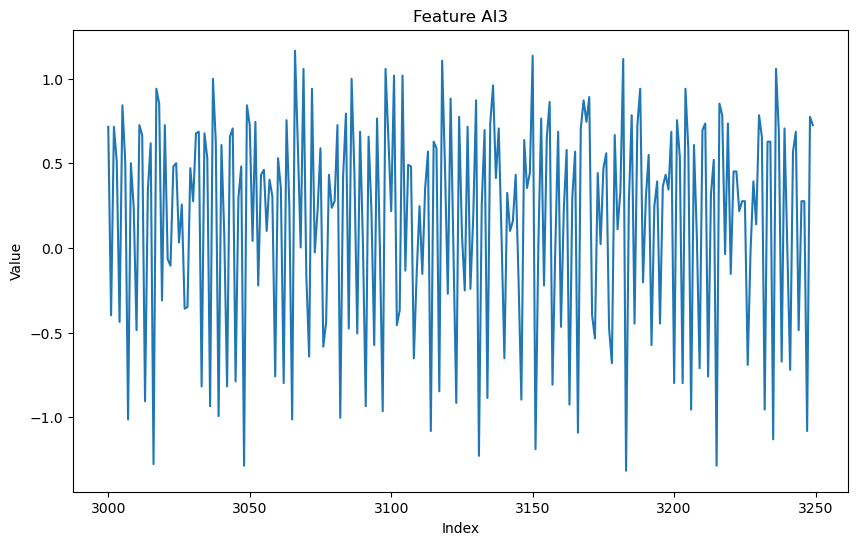

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df["AI3"][3000:3250])
plt.title('Feature AI3')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

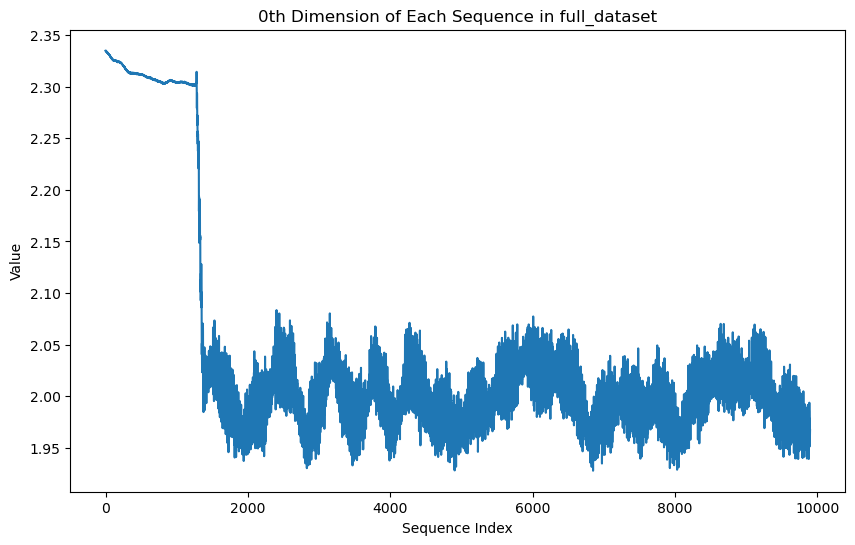

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(AI3)
plt.title('0th Dimension of Each Sequence in full_dataset')
plt.xlabel('Sequence Index')
plt.ylabel('Value')
plt.show()

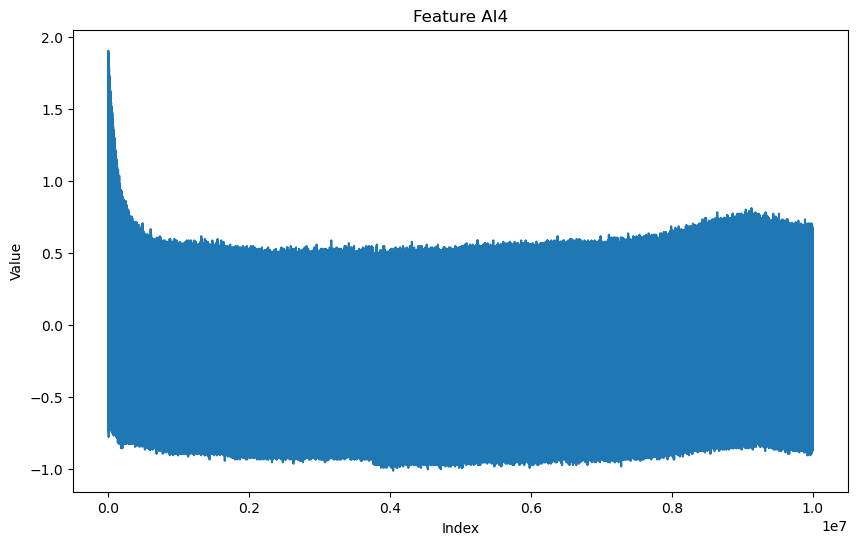

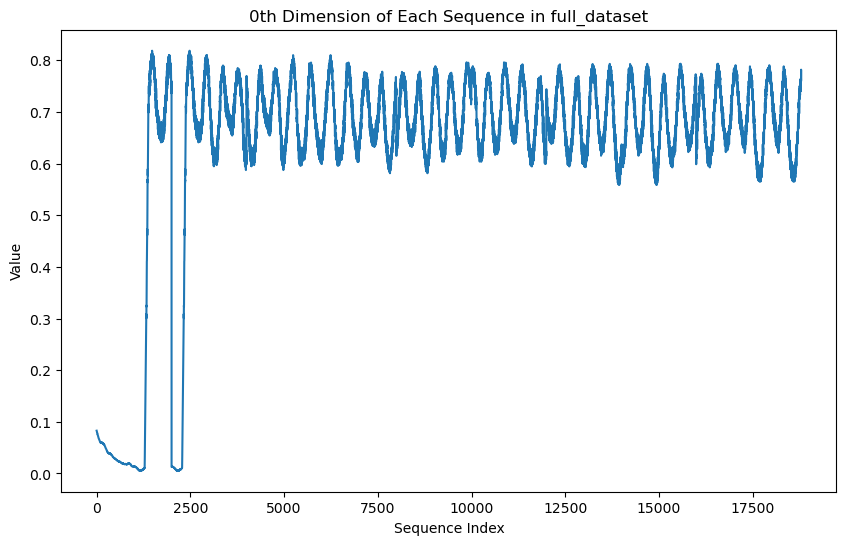

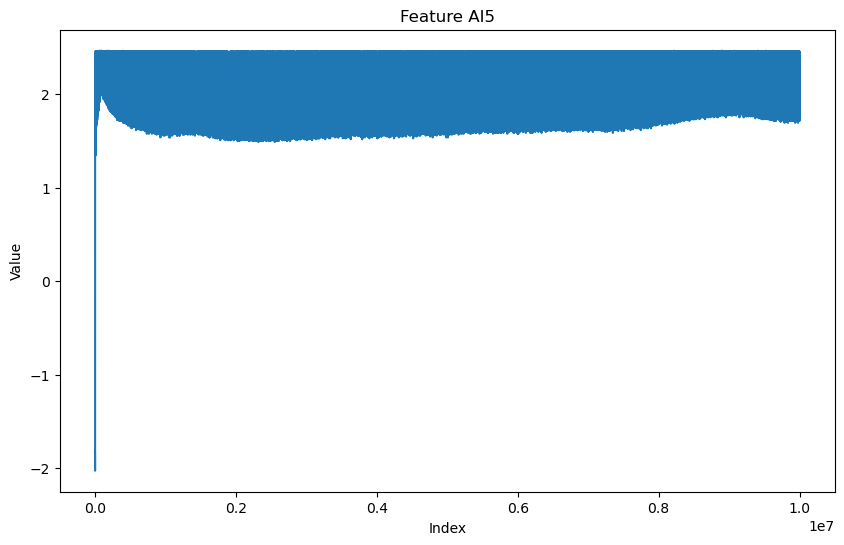

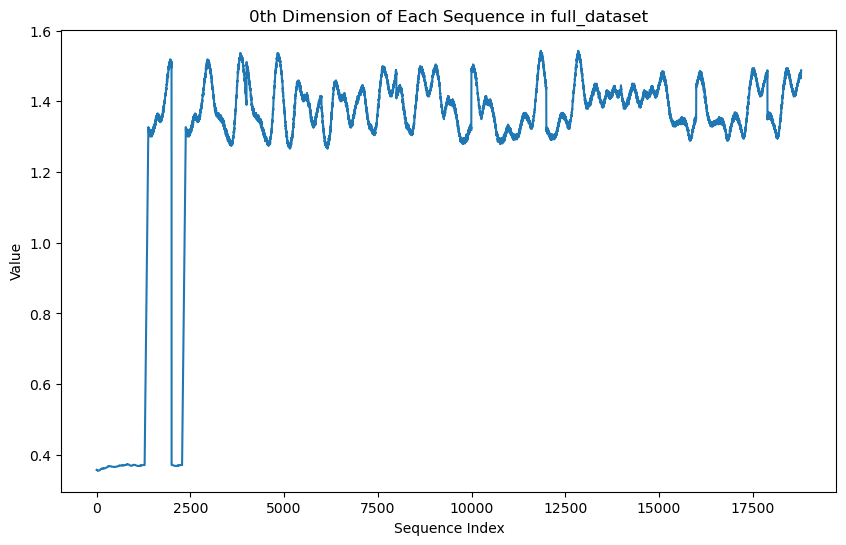

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df["AI4"])
plt.title('Feature AI4')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(AI4)
plt.title('0th Dimension of Each Sequence in full_dataset')
plt.xlabel('Sequence Index')
plt.ylabel('Value')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(df["AI5"])
plt.title('Feature AI5')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(AI5)
plt.title('0th Dimension of Each Sequence in full_dataset')
plt.xlabel('Sequence Index')
plt.ylabel('Value')
plt.show()

In [ ]:
def get_batch3(split):
    # Select the correct data split
    if split == 'train':
        a, b, max_index = x_A_train, x_B_train, int(length_read * 0.9) - block_size - 1
    else:  # split == 'test'
        a, b, max_index = x_A_test, x_B_test, length_read - (int(length_read * 0.9) + block_size + 1)

    # Generate random indices for batch selection, ensuring they're within bounds
    ix = torch.randint(0, max_index, (batch_size,))

    # Initialize lists to hold the batches
    x_batch = []
    y_batch = []

    for i in ix:
        try:
            # Extract sequences from 'a' and 'b' and the corresponding target from 'b'
            seq_A = torch.tensor(a.iloc[i.item():i.item() + block_size].astype(np.float32).values, dtype=torch.float32)
            seq_B = torch.tensor(b.iloc[i.item():i.item() + block_size - 1].astype(np.float32).values, dtype=torch.float32)
            target = torch.tensor(b.iloc[i.item() + block_size - 1].astype(np.float32).values, dtype=torch.float32)

            seq = torch.cat((seq_A, seq_B), dim=0)
            print(f"x_batch shape: {seq.shape}, y_batch shape: {target.shape}")
            x_batch.append(seq)
            y_batch.append(target)
        except IndexError as e:
            print(f"IndexError for index {i.item()}: {str(e)}")
            print(f"Attempting to access index [{i.item()}:{i.item() + block_size}] in 'a' with shape {a.shape}")
            print(f"Attempting to access index {i.item() + block_size} in 'b' with shape {b.shape}")
            # Optionally, break or continue depending on desired behavior on error
            break  # or continue

    if not x_batch or not y_batch:
        print("Error: Batch could not be created due to index issues.")
        return None, None

    # Stack the collected sequences and targets into tensors
    xstack = torch.stack(x_batch)
    ystack = torch.stack(y_batch)

    return xstack, ystack

In [18]:
get_batch3("train")

x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch shape: torch.Size([9, 3]), y_batch shape: torch.Size([3])
x_batch sh

(tensor([[[ 2.3565,  0.2466,  0.7741],
          [ 2.3565,  0.3443,  0.5495],
          [ 2.4542,  0.2173,  0.9206],
          ...,
          [ 0.5397,  0.1099,  2.0049],
          [ 1.0867,  0.0904,  2.4347],
          [ 0.0513,  0.3736,  1.9365]],
 
         [[ 2.2198,  0.7057,  1.1648],
          [ 2.1026,  0.7448,  1.0769],
          [ 2.1514,  0.9011,  0.8718],
          ...,
          [ 1.6630,  0.2759,  2.4151],
          [ 0.7448, -0.1734,  2.3468],
          [ 0.4127, -0.7399,  2.1319]],
 
         [[ 1.9365,  0.7448,  1.0183],
          [ 2.2686,  0.7350,  1.0281],
          [ 2.1416,  0.5006,  1.0574],
          ...,
          [ 0.6081, -0.2418,  2.2198],
          [ 1.1746, -0.3785,  2.4151],
          [ 0.4615, -0.1245,  1.8486]],
 
         ...,
 
         [[ 2.2491,  0.9499,  1.4481],
          [ 2.0830,  0.5885,  1.0379],
          [ 2.2002,  0.6276,  1.0965],
          ...,
          [ 0.8523, -0.3004,  2.3663],
          [-0.0757, -0.4957,  1.9267],
          [ 1.0476